<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [10]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving elsa (2).jpg to elsa (2) (1).jpg

Upload Style Image


Saving abstract_art2.jpg to abstract_art2.jpg
Content Path: <_io.BytesIO object at 0x7fef07c3c830>
Style Path: <_io.BytesIO object at 0x7fef07c3c650>


In [11]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()
#content and style image shapes are torch.Size([1, 3, 224, 224])


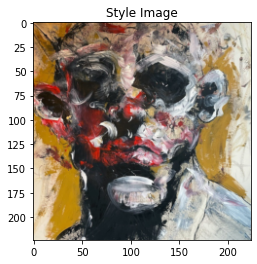

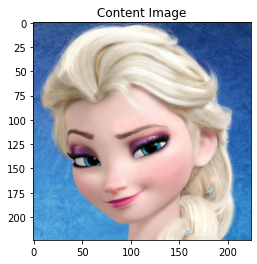

In [12]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

**DONE:**


* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image



In [13]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

# Used to Extract statistics from the input images
# It reasigns the forward hook of some of the layers of the VGG network
# Pass in a list of integers that say which layers I want
# Instead of giving you the output of the network, it
# gives you the list of the intermediate feature maps we told it to save
# That allows us to see whats going on in the middle of the network
# Those are the values that we will need for our style transfer loss functions

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates # Returns the list of the intermediate feature maps we told it to save
    # returns as a dictionary where the key is the later index and value is the feature map

In [14]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer

# content_layers_default = ['conv_4'] -> 17 , conv4_2 -> 19
content_layers_default = [17]

# style_layers_default = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']
style_layers_default = [0, 5, 10, 17, 24]

# Create the vgg network in eval mode
content_model = VGGIntermediate(content_layers_default) # These will be our targets when we do style transfer
content_model.cuda()
content_targets = content_model(content_image)

style_model = VGGIntermediate(style_layers_default)
style_model.cuda()
style_targets = style_model(style_image)

#  with our forward method that returns the outputs of the intermediate layers we requested

# Cache the outputs of the content and style layers for their respective images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [ ]:
style_embeddings[0].shape


torch.Size([1, 64, 224, 224])

___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

**DONE:**


* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object



In [15]:
def gram_matrix(input):
   a, b, c, d = input.size() 
   # a is batch size = 1
   # b is number of featuer maps
   # c and d are the dims of a f. map (N = c*d)

   features = input.view(a * b, c * d) # resize F_XL into \hat F_XL

   G = torch.mm(features, features.t()) # compute the gram product

   # we 'normalize' the values of the gram matrix
   # by dividing by the number of elements in each feature map
   return G.div(a * b * c * d)
  
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    # detach the traget content from the tree used
    # to dynamically compute the gradient: this is a stated value
    # not a variable. Otherwise the forward method of the criterion
    # will throw an error
    self.target = target.detach() # Detach from computation graph otherwise pytorch will throw an error.
    # because we've done things with these tensors they have a computation graph

  def forward(self, input):
    # pdb.set_trace()
    self.loss = F.mse_loss(input, self.target)
    return self.loss
    
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return self.loss


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



In [18]:
def run_style_transfer(style=1, content=1):
    # In the paper it starts with random noise
    input_image = content_image.clone() 

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_image.requires_grad_(True)

    # Run the optimizer on the images to change the image
    #  using the loss of the style and content layers
    #  to backpropagate errors 
    optimizer = optim.Adam([input_image], lr=.1)
    
    # Loss functions for each output for the corresponding dimensions (different layers have different dimensions)
    c_loss_fn = ContentLoss(target=content_targets[17])

    s_loss_fn1 = StyleLoss(target_feature=style_targets[0])
    s_loss_fn2 = StyleLoss(target_feature=style_targets[5])
    s_loss_fn3 = StyleLoss(target_feature=style_targets[10])
    s_loss_fn4 = StyleLoss(target_feature=style_targets[17])
    s_loss_fn5 = StyleLoss(target_feature=style_targets[24])

    num_iterations = 0
    STYLE = style
    CONTENT = content

    train_model = VGGIntermediate(style_layers_default).cuda().eval()
    

    while num_iterations < 2000:
        with torch.no_grad():
          input_image.clamp_(0, 1)
        # pdb.set_trace()
        optimizer.zero_grad() 
        # Re-run updated input image into model to get new content and style embeddings
        # new_content_embeddings = content_model(input_image)
        # new_style_embeddings = style_model(input_image)
        new_embeddings = train_model(input_image) # Technically the style embeddings

        # Calc Loss for each layer in Content Dictionary
        total_content_loss = c_loss_fn(new_embeddings[17])

        total_style_loss = s_loss_fn1(new_embeddings[0]) + \
                           s_loss_fn2(new_embeddings[5]) + \
                           s_loss_fn3(new_embeddings[10]) + \
                           s_loss_fn4(new_embeddings[17]) + \
                           s_loss_fn5(new_embeddings[24])
        # print('total content loss : ', total_content_loss.item())
        # print('total style loss: ', total_style_loss.item())

        total_loss = content * total_content_loss + style * total_style_loss
        # pdb.set_trace()
        total_loss.backward() # Stores the gradients in the grad attribute of tensors
        optimizer.step() # Makes the optimizer iterate over tensor and update them using internally stored grad values
        num_iterations += 1

        if num_iterations == 1:
          print('Iteration:{}, Content Loss:{:.4f}, Style Loss:{:.4f}'.format(num_iterations, content * total_content_loss, style * total_style_loss))
        if num_iterations % 50 == 0:
          # pdb.set_trace()
          print('Iteration:{}, Content Loss:{:.4f}, Style Loss:{:.4f}'.format(num_iterations, content * total_content_loss, style * total_style_loss))

          # plt.figure()
          # display(input_image, title='Style Image')
    return input_image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Iteration:1, Content Loss:0.0000, Style Loss:7.2378
Iteration:50, Content Loss:6.8146, Style Loss:7.0924
Iteration:100, Content Loss:6.5399, Style Loss:7.1360
Iteration:150, Content Loss:6.8369, Style Loss:7.2064
Iteration:200, Content Loss:6.0966, Style Loss:7.1323
Iteration:250, Content Loss:5.5797, Style Loss:7.1786
Iteration:300, Content Loss:5.7285, Style Loss:7.3955
Iteration:350, Content Loss:6.6468, Style Loss:7.2076
Iteration:400, Content Loss:6.9715, Style Loss:7.0290
Iteration:450, Content Loss:7.3632, Style Loss:6.6793
Iteration:500, Content Loss:6.4875, Style Loss:7.0513
Iteration:550, Content Loss:6.0227, Style Loss:7.0296
Iteration:600, Content Loss:5.8512, Style Loss:6.9400
Iteration:650, Content Loss:6.1941, Style Loss:7.1668
Iteration:700, Content Loss:5.9729, Style Loss:7.0707
Iteration:750, Content Loss:6.3711, Style Loss:7.2638
Iteration:800, Content Loss:6.4444, Style Loss:7.1281
Iteration:850, Content Loss:6.2104, Style Loss:7.0374
Iteration:900, Content Loss:5.2

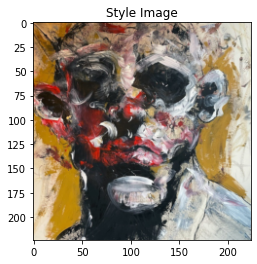

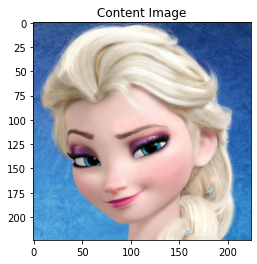

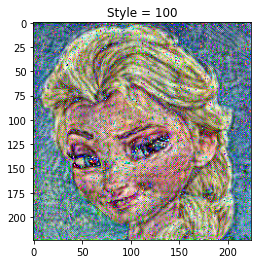

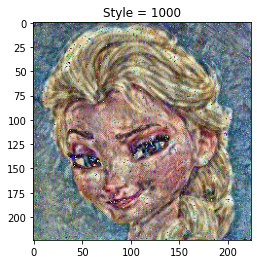

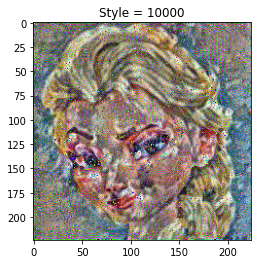

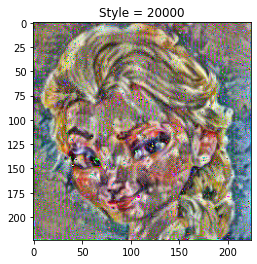

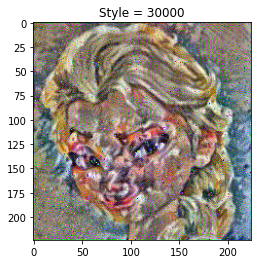

In [19]:
# Display the images
# toPIL = transforms.ToPILImage()  

# def display(tensor, title=None):
#     image = tensor.cpu().clone()  
#     image = image.squeeze(0)    
#     image = toPIL(image)
#     plt.imshow(image)
#     if title is not None:
#         plt.title(title)'
new_image = run_style_transfer(style=100, content=1)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')

plt.figure()
display(new_image, title='Style = 100')

new_image = run_style_transfer(style=1000, content=1)

plt.figure()
display(new_image, title='Style = 1000')

new_image = run_style_transfer(style=10000, content=1)

plt.figure()
display(new_image, title='Style = 10000')

new_image = run_style_transfer(style=20000, content=1)

plt.figure()
display(new_image, title='Style = 20000')

new_image = run_style_transfer(style=30000, content=1)

plt.figure()
display(new_image, title='Style = 30000')

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

**DONE:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

$\mathcal{L}_{content} (\vec{p},\vec{x},l) = \frac{1}{2} \sum_{i,j} (F_{ij}^l - P_{ij}^l)^2$

This is essentially the sum of squared errors. $\vec{p}$ is the original image and $\vec{x}$ is the image that is generated. $F_{ij}^l$ is the feature representation of $\vec{p}$ after being passed through the model. This is essentially our target. $P_{ij}^l$ is the feature representation of $\vec{p}$ after being changed by the optimizer. $i$ and $j$ represent the $ith$ filter at position $j$ in layer $l$ of our matrix.



- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.


$G_{ij}^l = \sum_k F_{ik}^l F_{jk}^l$

This is the equation for the Gram matrix. In order to compute the correlation between the different filter responses we can use the gram matrix. Our features consist of lines, edges, dots, curves etc, and if we can measure the correlation between these filtres, we can extract the style of an image. For example when feature1 occurs, if correlated with feature2 then feature2 will also be present.  $G_{ij}^l$ is the inner dot product between the vectorised feature map $i$ and $j$ in layer $l$. 


- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.


$E_l = \frac{1}{4 N_l^2 M_l^2} \sum_{i,j} (G_{ij}^l - A_{ij}^l)^2$

As we use gradient decent on a white noise image or in our case a copy of our content image, we minimize the mean-squared distance between the values in the gram matrix from our original image, and the gram matrix of our image we are generating. $G_{ij}^l$ is the style representation of the image we are generating nd $A_{ij}^l$ is the style representation of our original image (target) at the respective layer $l$. Outside of the summation we are taking the mean to get the loss for that particular layer.


- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.


$\mathcal{L}_{style} (\vec{a}, \vec{x}) = \sum_{l=0}^L w_l E_l$


After summing up the loss of each layer we get the total loss, found with this equation. $w$ is the weighting scalars of the contributions from each layer. If we want to have much more style in our image than content we weight the loss for the style with a higher value. Then we sum all the corresponding loss calculated at each layer. 

